1. Use the same dataset from the previous task
2. Reuse validation strategy and preprocessing without changes
3. Train xgboost model
4. Train lightgbm model
5. Train catboost model
6. Compare performance on local validation and on test set on kaggle

In [2]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [3]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [4]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

In [5]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

pclass_fare = {
    1: 30,
    2: 12,
    3: 7
}

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')
    
    data['fare_per_person'] = data['Pclass'].map(pclass_fare)
    data['people_per_ticket'] = (data['Fare'] / data['fare_per_person']).round().astype(int)
    data['is_zero_price'] = (data['Fare'] == 0).round().astype(int)
    
    data['family_size'] = data['SibSp'] + data['Parch'] + 1
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin', 'fare_per_person']) #, 'Fare', 'SibSp', 'Parch'

train_X = enhance_features(train_raw.drop(columns=['Survived']))
train_y = train_raw['Survived']

test_X = enhance_features(test_raw)

train_X

<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_5468\1988405248.py:20: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter,people_per_ticket,is_zero_price,family_size
PassengerId,,,,,,,,,,,,,,,,,
1,3,male,22.000000,1,0,7.2500,S,0,0,0,1,Mr,A/5,Unknown,1,0,2
2,1,female,38.000000,1,0,71.2833,C,0,0,0,0,Mrs,PC,C,2,0,2
3,3,female,26.000000,0,0,7.9250,S,0,0,0,1,Miss,STON/O2,Unknown,1,0,1
4,1,female,35.000000,1,0,53.1000,S,0,0,0,0,Mrs,,C,2,0,2
5,3,male,35.000000,0,0,8.0500,S,0,0,0,1,Mr,,Unknown,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,13.0000,S,0,0,0,1,Rev,,Unknown,1,0,1
888,1,female,19.000000,0,0,30.0000,S,0,0,0,0,Miss,,B,1,0,1
889,3,female,29.699118,1,2,23.4500,S,1,0,0,1,Miss,W/C,Unknown,3,0,4


# XGB

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

train_X_preprocessed = preprocessor.fit_transform(train_X)
test_X_preprocessed = preprocessor.transform(test_X)

feature_names = list(preprocessor.get_feature_names_out())
xgb_train = xgb.DMatrix(train_X_preprocessed, train_y, feature_names=feature_names)
xgb_test = xgb.DMatrix(test_X_preprocessed, feature_names=feature_names)

feature_names

['one_hot__Sex_female',
 'one_hot__Sex_male',
 'one_hot__Embarked_C',
 'one_hot__Embarked_Q',
 'one_hot__Embarked_S',
 'one_hot__title_Capt',
 'one_hot__title_Col',
 'one_hot__title_Don',
 'one_hot__title_Dr',
 'one_hot__title_Jonkheer',
 'one_hot__title_Lady',
 'one_hot__title_Major',
 'one_hot__title_Master',
 'one_hot__title_Miss',
 'one_hot__title_Mlle',
 'one_hot__title_Mme',
 'one_hot__title_Mr',
 'one_hot__title_Mrs',
 'one_hot__title_Ms',
 'one_hot__title_Rev',
 'one_hot__title_Sir',
 'one_hot__title_the Countess',
 'one_hot__ticket_prefix_',
 'one_hot__ticket_prefix_A/4',
 'one_hot__ticket_prefix_A/5',
 'one_hot__ticket_prefix_A/S',
 'one_hot__ticket_prefix_A4',
 'one_hot__ticket_prefix_A5',
 'one_hot__ticket_prefix_C',
 'one_hot__ticket_prefix_CA',
 'one_hot__ticket_prefix_CA/SOTON',
 'one_hot__ticket_prefix_FC',
 'one_hot__ticket_prefix_FCC',
 'one_hot__ticket_prefix_Fa',
 'one_hot__ticket_prefix_P/PP',
 'one_hot__ticket_prefix_PC',
 'one_hot__ticket_prefix_PP',
 'one_hot__t

In [20]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

xgb_parameters = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "eta": 0.1,

    # regularization parameters
    "max_depth": 5,
    #"max_leaves": 32,
    "subsample": 0.7,
    "colsample_bytree": 0.8,

    #lightgbm approach
    # "tree_method": "hist",
    # "grow_policy": "lossguide"
}

xgb_cv_results = xgb.cv(
    xgb_parameters, 
    xgb_train,
    folds=cv,
    num_boost_round=1000, 
    early_stopping_rounds=10, 
    verbose_eval=10
)

n_estimators = xgb_cv_results.shape[0]

print(xgb_cv_results[-1:])
print('Params: ', xgb_parameters)
print('n_estimators: ', n_estimators)

[0]	train-error:0.38384+0.00042	test-error:0.38383+0.00375
[10]	train-error:0.13056+0.00430	test-error:0.16494+0.04778
[20]	train-error:0.12034+0.00434	test-error:0.16719+0.04816
[21]	train-error:0.11922+0.00597	test-error:0.16719+0.04405
    train-error-mean  train-error-std  test-error-mean  test-error-std
11          0.127696          0.00409         0.160449         0.05083
Params:  {'objective': 'binary:logistic', 'eval_metric': 'error', 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.8}
n_estimators:  12


In [38]:
print(f'Mean accuracy on cv train: {1 - xgb_cv_results['train-error-mean'].iat[-1]}')
print(f'Mean accuracy on cv test: {1 - xgb_cv_results['test-error-mean'].iat[-1]}')

Mean accuracy on cv train: 0.8723037910840875
Mean accuracy on cv test: 0.8395505617977528


In [39]:
xgb_model = xgb.train(xgb_parameters, xgb_train, num_boost_round=n_estimators)

xgb_train_y_predict = (xgb_model.predict(xgb_train) >= 0.5).astype(int)
xgb_train_score = accuracy_score(xgb_train_y_predict, np.array(train_y))
print(f'Accuracy on all train: {xgb_train_score}')

Accuracy on all train: 0.8698092031425365


In [40]:
xgb_test_with_pred = test_X.copy()

xgb_test_with_pred['Survived'] = (xgb_model.predict(xgb_test) >= 0.5).astype(int)
xgb_test_with_pred['Survived'].to_csv('xgb_test_results.csv', index=True)

# Verify result csv hasn't changed since prev HW

# LightGBM

We saw on xgb example that titanic dataset is small and early stopping doesn't improve time much. So let's just use grid search without early stopping

In [21]:
categorical_feature = ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = make_scorer(accuracy_score)

def make_categorical_columns(df):
    df_lgb_adjusted = df.copy()
    for col in categorical_feature:
        df_lgb_adjusted[col] = df_lgb_adjusted[col].astype('category')
        
    return df_lgb_adjusted

lgb_train = lgb.Dataset(make_categorical_columns(train_X), label=train_y, free_raw_data=False)
lgb_test = lgb.Dataset(make_categorical_columns(test_X), free_raw_data=False)

In [27]:
lgb_params1 = {
    'objective': 'binary',
    'metric': 'binary_logloss', # 'auc'
    'boosting_type': 'gbdt',
    'verbosity': -1    
}
lgb_rounds = 1000
    
lgb_results1 = lgb.cv(lgb_params1, lgb_train, lgb_rounds, folds=cv, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(period=100)])
lgb_rounds1_ = len(list(lgb_results1.items())[0][1])

lgbClassifier1 = lgb.LGBMClassifier(random_state=3, **lgb_params1, lgb_rounds=lgb_rounds1_)
lgbClassifier_results1 = cross_val_score(lgbClassifier1, make_categorical_columns(train_X), train_y, cv=cv, scoring=scoring)
print(f'accuracy score on cross-validation: {lgbClassifier_results1.mean()}')

lgbClassifier1.fit(make_categorical_columns(train_X), train_y)
lgb_train_y_predict1 = (lgbClassifier1.predict(make_categorical_columns(train_X)) >= 0.5).astype(int)
lgb_train_score1 = accuracy_score(lgb_train_y_predict1, np.array(train_y))
print(f'accuracy score on all train data: {lgb_train_score1}')

c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.413101 + 0.0622608
accuracy score on cross-validation: 0.8249188514357053
accuracy score on all train data: 0.9595959595959596


In [54]:
lgb_params2 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    "learning_rate": 0.01,

    #regularization
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "min_data_in_leaf": 15,

    #categorical features
    'cat_smooth': 10,
    'min_data_per_group': 50
}
# best_params: {'boosting_type': 'gbdt', 'cat_smooth': 10, 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'metric': 'binary_logloss', 'min_data_in_leaf': 5, 'min_data_per_group': 20, 'num_leaves': 8, 'subsample': 0.4}
# accuracy score on cross-validation: 0.8338202247191011

lgb_rounds = 1000
    
lgb_results2 = lgb.cv(lgb_params2, lgb_train, lgb_rounds, folds=cv, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(period=100)])
lgb_rounds2_ = len(list(lgb_results2.items())[0][1])

lgbClassifier2 = lgb.LGBMClassifier(random_state=3, **lgb_params2, lgb_rounds=lgb_rounds2_)
lgbClassifier_results2 = cross_val_score(lgbClassifier2, make_categorical_columns(train_X), train_y, cv=cv, scoring=scoring)
print(f'Paraemters: {lgb_params2}')
print(f'accuracy score on cross-validation: {lgbClassifier_results2.mean()}')

lgbClassifier2.fit(make_categorical_columns(train_X), train_y)
lgb_train_y_predict2 = (lgbClassifier2.predict(make_categorical_columns(train_X)) >= 0.5).astype(int)
lgb_train_score2 = accuracy_score(lgb_train_y_predict2, np.array(train_y))
print(f'accuracy score on all train data: {lgb_train_score2}')


c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 10 rounds
[100]	cv_agg's valid binary_logloss: 0.465583 + 0.0353079
[200]	cv_agg's valid binary_logloss: 0.418851 + 0.0488093
[300]	cv_agg's valid binary_logloss: 0.410587 + 0.0541758
Early stopping, best iteration is:
[294]	cv_agg's valid binary_logloss: 0.410293 + 0.0538444
Paraemters: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'subsample': 0.8, 'subsample_freq': 1, 'min_data_in_leaf': 15, 'cat_smooth': 10, 'min_data_per_group': 50}
accuracy score on cross-validation: 0.819338327091136
accuracy score on all train data: 0.8608305274971941


In [37]:
lgbm_test_results1 = test_X.copy()
lgbm_test_results1['Survived'] = (lgbClassifier1.predict(make_categorical_columns(test_X)) >= 0.5).astype(int)
lgbm_test_results1['Survived'].to_csv('lgbm_test_results1.csv', index=True)

lgbm_test_results2 = test_X.copy()
lgbm_test_results2['Survived'] = (lgbClassifier2.predict(make_categorical_columns(test_X)) >= 0.5).astype(int)
lgbm_test_results2['Survived'].to_csv('lgbm_test_results2.csv', index=True)

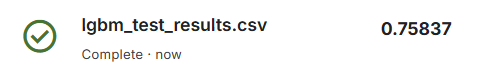

# Cat Boost

In [38]:
cat_train = ctb.Pool(make_categorical_columns(train_X), train_y, cat_features=categorical_feature)
cat_test = ctb.Pool(make_categorical_columns(test_X), cat_features=categorical_feature)

In [45]:
cat_parameters1 = {
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    
    "iterations": 1000,
    "learning_rate": 0.1,
    "od_wait": 50,
    "od_type": "Iter",
}

cat_result_1 = ctb.cv(cat_train, cat_parameters1, folds=cv, seed=3, verbose_eval=100, plot=True)

c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.8089888	test: 0.7888889	best: 0.7888889 (0)	total: 52.8ms	remaining: 52.8s

bestTest = 0.8111111111
bestIteration = 1

Training on fold [1/10]
0:	learn: 0.8241895	test: 0.8089888	best: 0.8089888 (0)	total: 37ms	remaining: 36.9s

bestTest = 0.8651685393
bestIteration = 27

Training on fold [2/10]
0:	learn: 0.8341646	test: 0.7528090	best: 0.7528090 (0)	total: 36.1ms	remaining: 36.1s

bestTest = 0.797752809
bestIteration = 10

Training on fold [3/10]
0:	learn: 0.8054863	test: 0.9101124	best: 0.9101124 (0)	total: 32.9ms	remaining: 32.9s

bestTest = 0.9438202247
bestIteration = 32

Training on fold [4/10]
0:	learn: 0.8266833	test: 0.7528090	best: 0.7528090 (0)	total: 32.3ms	remaining: 32.3s

bestTest = 0.797752809
bestIteration = 34

Training on fold [5/10]
0:	learn: 0.8179551	test: 0.8314607	best: 0.8314607 (0)	total: 28.4ms	remaining: 28.4s

bestTest = 0.8651685393
bestIteration = 34

Training on fold [6/10]
0:	learn: 0.8229426	test: 0.7865169	best: 0.7

In [46]:
cat_result_1.loc[cat_result_1["test-Accuracy-mean"] == cat_result_1["test-Accuracy-mean"].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
41,41,0.840674,0.051641,0.868937,0.006819,0.407593,0.056332,0.335087,0.007684
42,42,0.840674,0.052982,0.869311,0.006904,0.407387,0.056305,0.333929,0.007959


In [55]:
cat_parameters1['iterations'] = 43
catboost_model = ctb.CatBoostClassifier(**cat_parameters1)
catboost_model.fit(cat_train, verbose_eval=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114478	total: 33ms	remaining: 1.39s
42:	learn: 0.8305275	total: 1.24s	remaining: 0us


In [58]:
print('Params: ', cat_parameters1)
print('accuracy score on all train data:', accuracy_score(catboost_model.predict(cat_train), train_y))

Params:  {'loss_function': 'Logloss', 'eval_metric': 'Accuracy', 'iterations': 43, 'learning_rate': 0.1, 'od_wait': 50, 'od_type': 'Iter'}
accuracy score on all train data: 0.8383838383838383


In [59]:
cat_test_results = test_X.copy()
cat_test_results['Survived'] = catboost_model.predict(cat_test)
cat_test_results['Survived'].to_csv('cat_test_results.csv', index=True)

### XGBoost
- Params:  {'objective': 'binary:logistic', 'eval_metric': 'error', 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.8}
- accuracy score on cross-validation: 0.830561797752809
- accuracy score on all train data: 0.8698092031425365

### LGBM
- Paraemters: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'subsample': 0.8, 'subsample_freq': 1, 'min_data_in_leaf': 15, 'cat_smooth': 10, 'min_data_per_group': 50}
- accuracy score on cross-validation: 0.819338327091136
- accuracy score on all train data: 0.8608305274971941

### CatBoost
- Params:  {'loss_function': 'Logloss', 'eval_metric': 'Accuracy', 'iterations': 43, 'learning_rate': 0.1, 'od_wait': 50, 'od_type': 'Iter'}
- accuracy score on all train data: 0.8383838383838383


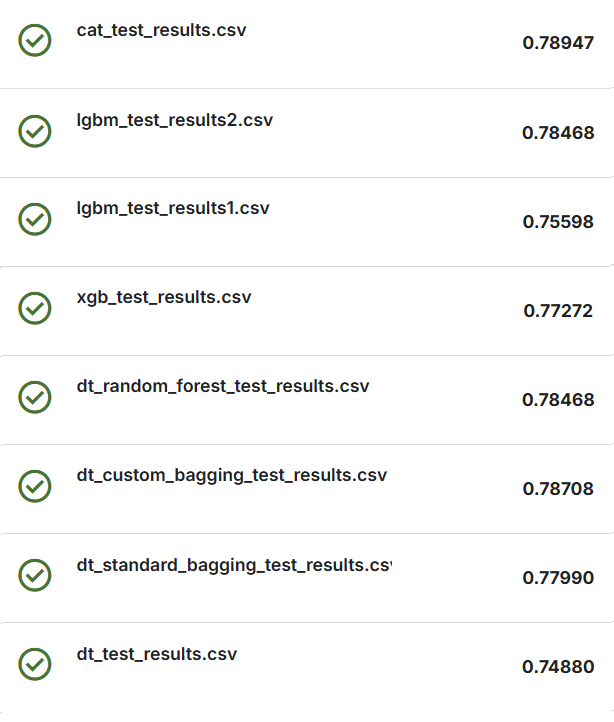